**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data and predict by zero-shot**.
<p>

In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

In [ ]:
!pip install -q monai

In [ ]:
!pip install patchify

In [ ]:
!pip install scikit-learn

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [9]:
# Load tiff stack images and masks
images = tifffile.imread('D:/Osher/ann_osher/YOLO_DATABASE_PANNELS/beer_sheva_2017/rgb_stack_full.tif')
masks = tifffile.imread('D:/Osher/ann_osher/YOLO_DATABASE_PANNELS/beer_sheva_2017/masks_stack_full.tif')

In [10]:
images.shape

(2102, 256, 256, 3)

In [ ]:
Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [4]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [4]:
images.shape

(94, 256, 256, 3)

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [11]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.sum() > 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (2092, 256, 256, 3)
Mask shape: (2092, 256, 256)


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [12]:
from datasets import Dataset
from PIL import Image
import numpy as np

# Ensure the images are in uint8 format and 3 channels
filtered_images_uint8 = (filtered_images).astype(np.uint8)

# Ensure the masks are in uint8 format and single channel
filtered_masks_uint8 = (filtered_masks).astype(np.uint8)

# Convert the images and masks from NumPy arrays to lists of Pillow images
filtered_images_list = [Image.fromarray(img) for img in filtered_images_uint8]
filtered_masks_list = [Image.fromarray(mask, mode='L') for mask in filtered_masks_uint8]

# Create the dataset using the datasets.Dataset class
dataset_dict = {
    "image": filtered_images_list,
    "label": filtered_masks_list,
}

# Convert the dataset dictionary to a Hugging Face Dataset
dataset = Dataset.from_dict(dataset_dict)

print(dataset)


Dataset({
    features: ['image', 'label'],
    num_rows: 2092
})


In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 94
})

Let us make sure out images and masks (labels) are loading appropriately

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random image and mask from the dataset
img_num = random.randint(0, filtered_images.shape[0] - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left (RGB image)
axes[0].imshow(np.array(example_image))  # No need for cmap since it's an RGB image
axes[0].set_title("Image")

# Plot the second image on the right (grayscale mask)
axes[1].imshow(example_mask, cmap='gray')  # Use cmap='gray' for the mask
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [14]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    image = np.array(image)

    # Check if the image is grayscale and convert it to RGB
    if image.ndim == 2:  # Image is grayscale
        image = np.expand_dims(image, axis=-1)  # Expand dimensions to (H, W, 1)
        image = np.repeat(image, 3, axis=2)    # Repeat the grayscale values across the new channel dimension

    ground_truth_mask = np.array(item["label"])

    # Get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # Remove batch dimension which the processor adds by default
    inputs = {k: v.squeeze(0) for k, v in inputs.items()}

    # Add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

In [17]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [19]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [22]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')


In [24]:
import torch

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have a model object
model = model  # Replace YourModel() with your actual model instantiation

# Move the model to the appropriate device
model.to(device)

# Print if model is using GPU or CPU
if device.type == 'cuda':
    print("Model is using GPU.")
else:
    print("Model is using CPU.")


Model is using GPU.


In [21]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Print the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # If more than one GPU is available, select the second GPU (index 1)
    if num_gpus > 1:
        second_gpu_index = 1
        device = torch.device(f"cuda:{second_gpu_index}")
        
        # Set the default device to the second GPU
        torch.cuda.set_device(second_gpu_index)
        
        # Verify the current device is set to the second GPU
        print(f"Current device index: {torch.cuda.current_device()}")
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        device = torch.device("cuda:0")
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Print if using GPU or CPU
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    print("Using CPU.")


Number of GPUs available: 2
Current device index: 1
Using GPU: NVIDIA RTX A4000
Using GPU: NVIDIA RTX A4000


In [22]:
import torch
print(torch.cuda.is_available())  # Should print: True if CUDA is available
print(torch.cuda.current_device())  # Should print the current CUDA device index
print(torch.cuda.get_device_name(0))  # Should print the name of the GPU

True
1
NVIDIA RTX A4000


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

    # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [26]:
# Save the model's state dictionary to a file
#torch.save(model.state_dict(), "D:/Osher/ann_osher/train/asaf18.pth")

**Inference**

In [1]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [36]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-large")
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create an instance of the model architecture with the loaded configuration
my_sinkhole_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_sinkhole_model.load_state_dict(torch.load( "D:/Osher/ann_osher/train/asaf18.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_sinkhole_model.to(device)

Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

Processing bbox 1: class_id=0.0, x_min=205.3885955810547, y_min=0.22709999978542328, x_max=255.4199981689453, y_max=98.58419799804688, confidence=0.7426000237464905
Processing bbox 2: class_id=0.0, x_min=22.826200485229492, y_min=0.0, x_max=81.05380249023438, y_max=70.377197265625, confidence=0.7200000286102295
Processing bbox 3: class_id=0.0, x_min=61.62379837036133, y_min=67.44539642333984, x_max=167.61329650878906, y_max=179.4967041015625, confidence=0.6868000030517578
Processing bbox 4: class_id=0.0, x_min=0.1145000010728836, y_min=0.1307000070810318, x_max=17.54439926147461, y_max=33.54560089111328, confidence=0.4799000024795532
Processing bbox 5: class_id=0.0, x_min=223.98629760742188, y_min=139.48809814453125, x_max=255.90530395507812, y_max=240.08180236816406, confidence=0.4691999852657318
Processing bbox 6: class_id=0.0, x_min=205.64610290527344, y_min=40.18669891357422, x_max=255.9748992919922, y_max=98.3677978515625, confidence=0.45419999957084656
Processing bbox 7: class_id

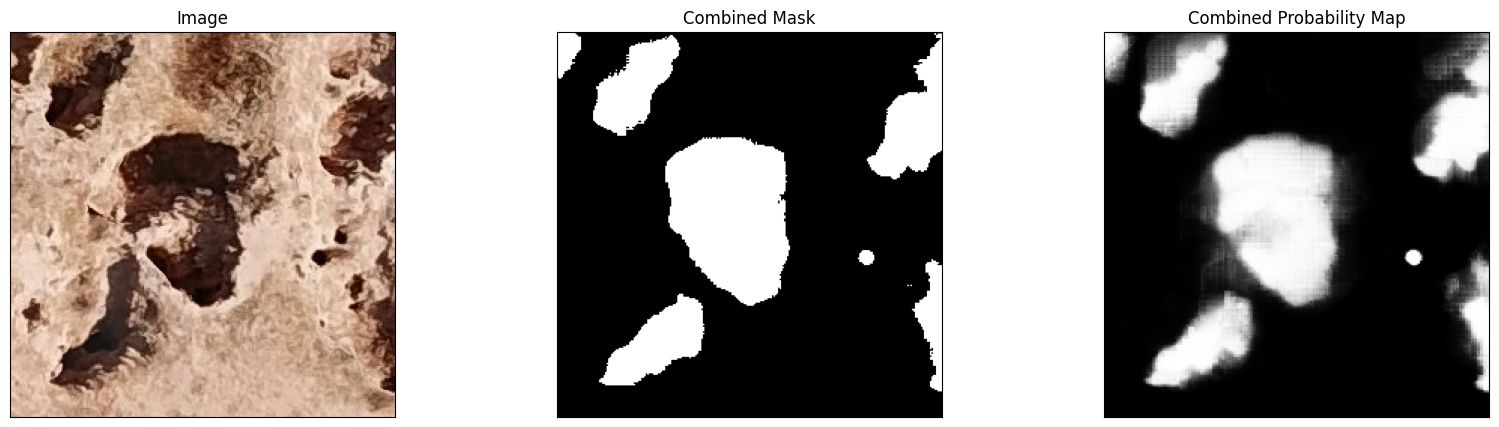

Combined mask saved as combined_mask.tif


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from rasterio.transform import from_origin

# Assuming `processor` and `my_sinkhole_model` are predefined and loaded

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_boxes_from_txt(file_path):
    """
    Read bounding boxes from a text file in the format: class_id x_min y_min x_max y_max confidence
    
    :param file_path: Path to the text file
    :return: Tensor containing bounding boxes
    """
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_min, y_min, x_max, y_max, confidence = map(float, parts[1:])
            boxes.append([x_min, y_min, x_max, y_max, confidence, class_id])
    return torch.tensor(boxes, device=device)

def read_tfw(tfw_path):
    """
    Read the georeferencing information from a .tfw file
    
    :param tfw_path: Path to the .tfw file
    :return: transform (Affine transform)
    """
    with open(tfw_path, 'r') as file:
        lines = file.readlines()
    pixel_size_x = float(lines[0])
    rotation_1 = float(lines[1])
    rotation_2 = float(lines[2])
    pixel_size_y = -float(lines[3])
    upper_left_x = float(lines[4])
    upper_left_y = float(lines[5])
    transform = from_origin(upper_left_x, upper_left_y, pixel_size_x, abs(pixel_size_y))
    return transform

def process_bboxes_and_generate_mask(image_path, bboxes_tensor):
    """
    Process bounding boxes and generate combined mask.
    
    :param image_path: Path to the image
    :param bboxes_tensor: Tensor containing bounding boxes in the format [x_min, y_min, x_max, y_max, confidence, class_id]
    :return: Combined probability map and combined mask
    """
    # Read the image to get dimensions
    image = Image.open(image_path)
    img_w, img_h = image.size

    # Convert tensor to numpy array
    bboxes_pixel = bboxes_tensor.cpu().numpy()
    
    # Initialize an array to store the combined probability map
    combined_prob_map = np.zeros((img_h, img_w), dtype=np.float32)

    # Process each bounding box
    for i, bbox in enumerate(bboxes_pixel):
        x_min, y_min, x_max, y_max, confidence, class_id = bbox
        # Skip low confidence detections if needed
        if confidence < 0.3:
            continue
        
        print(f"Processing bbox {i+1}: class_id={class_id}, x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}, confidence={confidence}")
        
        # Create a box prompt in the format required by the processor
        prompt = [x_min, y_min, x_max, y_max]
        
        # Prepare image + box prompt for the model
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU if it's not already there
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Move the model to the device
        my_sinkhole_model.to(device)
        my_sinkhole_model.eval()

        # Forward pass
        with torch.no_grad():
            outputs = my_sinkhole_model(**inputs, multimask_output=False)

        # Apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # Convert soft mask to numpy array and combine it with the existing probability map
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        combined_prob_map = np.maximum(combined_prob_map, medsam_seg_prob)

    # Convert the combined probability map to a hard mask
    combined_mask = (combined_prob_map > 0.5).astype(np.uint8)
    
    return combined_prob_map, combined_mask

# Example usage
image_path = "D:/Osher/ann_osher/test/yolo_test/yolo_dataset/train/images/000000000040.tif"
bbox_file_path = "detected_boxes1.txt"  # Path to the text file containing bounding boxes

# Read bounding boxes from the text file
bboxes_tensor = read_boxes_from_txt(bbox_file_path)

# Process bounding boxes and generate the combined mask
combined_prob_map, combined_mask = process_bboxes_and_generate_mask(image_path, bboxes_tensor)

# Print out the shapes and types of the masks
print(f"combined_prob_map shape: {combined_prob_map.shape}, dtype: {combined_prob_map.dtype}")
print(f"combined_mask shape: {combined_mask.shape}, dtype: {combined_mask.dtype}")

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot the original image on the left
image = Image.open(image_path).convert('RGB')
axes[0].imshow(np.array(image))  # Display the RGB image
axes[0].set_title("Image")

# Plot the combined mask in the middle
axes[1].imshow(combined_mask, cmap='gray', vmin=0, vmax=1)  # Display the hard mask with proper scaling
axes[1].set_title("Combined Mask")

# Plot the combined probability map on the right
axes[2].imshow(combined_prob_map, cmap='gray', vmin=0, vmax=1)  # Display the probability map with proper scaling
axes[2].set_title("Combined Probability Map")

# Hide axis ticks and labels for all plots
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Read the georeferencing information from the .tfw file
tfw_path = image_path.replace('.tif', '.tfw')
transform = read_tfw(tfw_path)

# Correct WKT for EPSG:2039 (ITM)
itm_wkt = """
PROJCS["Israel_TM_Grid",
    GEOGCS["GCS_Israel",
        DATUM["D_Israel",
            SPHEROID["GRS_1980",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",31.73439361111111],
    PARAMETER["central_meridian",35.20451694444445],
    PARAMETER["scale_factor",1.0000067],
    PARAMETER["false_easting",219529.584],
    PARAMETER["false_northing",626907.39],
    UNIT["Meter",1]]
"""

# Save the combined mask as a TIFF file with georeferencing information
output_tiff_path = "combined_mask.tif"
with rasterio.open(
    output_tiff_path,
    'w',
    driver='GTiff',
    height=combined_mask.shape[0],
    width=combined_mask.shape[1],
    count=1,
    dtype='uint8',
    crs=itm_wkt,  # Using the WKT for ITM
    transform=transform
) as dst:
    dst.write(combined_mask, 1)
print(f"Combined mask saved as {output_tiff_path}")


In [ ]:
import os ##tuned-SAM with bouding boxes of closed depressions \ YOLO
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from skimage.transform import resize  # Import resize from skimage

# Assuming `processor` and `my_sinkhole_model` are predefined and loaded

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_boxes_from_txt(file_path):
    """
    Read bounding boxes from a text file in the format: class_id x_min y_min x_max y_max confidence
    
    :param file_path: Path to the text file
    :return: Tensor containing bounding boxes
    """
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_min, y_min, x_max, y_max, confidence = map(float, parts[1:])
            boxes.append([x_min, y_min, x_max, y_max, confidence, class_id])
    return torch.tensor(boxes, device=device)

def read_tfw(tfw_path):
    """
    Read the georeferencing information from a .tfw file
    
    :param tfw_path: Path to the .tfw file
    :return: transform (Affine transform)
    """
    with open(tfw_path, 'r') as file:
        lines = file.readlines()
    pixel_size_x = float(lines[0])
    rotation_1 = float(lines[1])
    rotation_2 = float(lines[2])
    pixel_size_y = -float(lines[3])
    upper_left_x = float(lines[4])
    upper_left_y = float(lines[5])
    transform = from_origin(upper_left_x, upper_left_y, pixel_size_x, abs(pixel_size_y))
    return transform

def process_bboxes_and_generate_mask(image_path, bboxes_tensor):
    """
    Process bounding boxes and generate combined mask.
    
    :param image_path: Path to the image
    :param bboxes_tensor: Tensor containing bounding boxes in the format [x_min, y_min, x_max, y_max, confidence, class_id]
    :return: Combined probability map and combined mask
    """
    # Read the image to get dimensions
    image = Image.open(image_path)
    img_w, img_h = image.size

    # Check if the image has an alpha channel (4 bands) and skip if it does
    if image.mode == 'RGBA' or image.mode == 'LA' or (image.mode == 'P' and 'transparency' in image.info):
        print(f"Skipping {image_path} as it has an alpha channel")
        return None, None

    # Convert image to RGB if it's not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert tensor to numpy array
    bboxes_pixel = bboxes_tensor.cpu().numpy()
    
    # Initialize an array to store the combined probability map
    combined_prob_map = np.zeros((img_h, img_w), dtype=np.float32)

    # Process each bounding box
    for i, bbox in enumerate(bboxes_pixel):
        x_min, y_min, x_max, y_max, confidence, class_id = bbox
        # Skip low confidence detections if needed
        if confidence < 0.15:
            continue
        
        print(f"Processing bbox {i+1}: class_id={class_id}, x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}, confidence={confidence}")
        
        # Create a box prompt in the format required by the processor
        prompt = [x_min, y_min, x_max, y_max]
        
        # Prepare image + box prompt for the model
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU if it's not already there
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Move the model to the device
        my_sinkhole_model.to(device)
        my_sinkhole_model.eval()

        # Forward pass
        with torch.no_grad():
            outputs = my_sinkhole_model(**inputs, multimask_output=False)

        # Apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # Convert soft mask to numpy array
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()

        # Resize the probability map to match the original image size
        medsam_seg_prob_resized = resize(medsam_seg_prob, (img_h, img_w), anti_aliasing=True)

        # Combine it with the existing probability map
        combined_prob_map = np.maximum(combined_prob_map, medsam_seg_prob_resized)

    # Convert the combined probability map to a hard mask
    combined_mask = (combined_prob_map > 0.5).astype(np.uint8)
    
    return combined_prob_map, combined_mask

def process_folder(image_folder, bbox_folder, output_folder):
    """
    Process a folder of images and corresponding bounding boxes, generate combined masks, and save the results.
    
    :param image_folder: Path to the folder containing images
    :param bbox_folder: Path to the folder containing bounding boxes
    :param output_folder: Path to the folder to save the combined masks
    """
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            image_path = os.path.join(image_folder, filename)
            bbox_file_path = os.path.join(bbox_folder, filename.replace(".tif", ".txt").replace(".tiff", ".txt"))

            # Read bounding boxes from the text file
            bboxes_tensor = read_boxes_from_txt(bbox_file_path)

            # Process bounding boxes and generate the combined mask
            combined_prob_map, combined_mask = process_bboxes_and_generate_mask(image_path, bboxes_tensor)

            if combined_mask is None:
                continue

            # Read the georeferencing information from the .tfw file
            tfw_path = image_path.replace('.tif', '.tfw')
            transform = read_tfw(tfw_path)

            # Save the combined mask as a TIFF file with georeferencing information
            output_tiff_path = os.path.join(output_folder, filename.replace(".tif", "_combined_mask.tif").replace(".tiff", "_combined_mask.tiff"))
            with rasterio.open(
                output_tiff_path,
                'w',
                driver='GTiff',
                height=combined_mask.shape[0],
                width=combined_mask.shape[1],
                count=1,
                dtype='uint8',
                crs=itm_wkt,  # Using the WKT for ITM
                transform=transform
            ) as dst:
                dst.write(combined_mask, 1)
            print(f"Processed {filename} and saved combined mask to {output_tiff_path}")

# Correct WKT for EPSG:2039 (ITM)
itm_wkt = """
PROJCS["Israel_TM_Grid",
    GEOGCS["GCS_Israel",
        DATUM["D_Israel",
            SPHEROID["GRS_1980",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",31.73439361111111],
    PARAMETER["central_meridian",35.20451694444445],
    PARAMETER["scale_factor",1.0000067],
    PARAMETER["false_easting",219529.584],
    PARAMETER["false_northing",626907.39],
    UNIT["Meter",1]]
"""

# Define the folder paths
image_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/final_test_512_new/images/"
bbox_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/final_test_512_new/images2/boxes_from_masks/"
output_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/final_test_512_new/results/sam/masks_box/"

# Process the folder
process_folder(image_folder, bbox_folder, output_folder)


In [ ]:
import os ##tuned-SAM with points centriod of closed depressions
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from skimage.transform import resize  # Import resize from skimage

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_points_from_txt(file_path):
    """
    Read points from a text file containing just (x, y) coordinates.
    
    :param file_path: Path to the text file
    :return: List of points containing coordinates
    """
    points = []
    with open(file_path, 'r') as file:
        for line in file:
            # Replace commas with spaces and split the line
            parts = [p.strip() for p in line.replace(",", " ").split()]
            
            # Ensure the line contains at least two values for x and y
            if len(parts) >= 2:
                x, y = map(float, parts[:2])  # Read x and y coordinates
                points.append([x, y])
            else:
                print(f"Invalid line format in file {file_path}: {line}")
    
    return points  # Return a list of points, not a tensor

def process_points_and_generate_mask(image_path, points, model):
    """
    Process points and generate combined mask.
    
    :param image_path: Path to the image
    :param points: List containing points in the format [[x, y], [x, y], ...]
    :param model: SAM model
    :return: Combined probability map and combined mask
    """
    # Read the image to get dimensions
    image = Image.open(image_path)
    img_w, img_h = image.size

    # Check if the image has an alpha channel (4 bands) and skip if it does
    if image.mode == 'RGBA' or image.mode == 'LA' or (image.mode == 'P' and 'transparency' in image.info):
        print(f"Skipping {image_path} as it has an alpha channel")
        return None, None

    # Convert image to RGB if it's not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Prepare image + points for the model
    inputs = processor(images=image, input_points=[points], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Move the model to the device
    model.to(device)
    model.eval()

    # Forward pass with all points together
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # Convert soft mask to numpy array
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()

    # Resize the probability map to match the original image size
    medsam_seg_prob_resized = resize(medsam_seg_prob, (img_h, img_w), anti_aliasing=True)

    # Convert the probability map to a hard mask
    combined_mask = (medsam_seg_prob_resized > 0.5).astype(np.uint8)
    
    return medsam_seg_prob_resized, combined_mask

def process_folder(image_folder, points_folder, output_folder, processor, model):
    """
    Process a folder of images and corresponding points, generate combined masks, and save the results.
    
    :param image_folder: Path to the folder containing images
    :param points_folder: Path to the folder containing points
    :param output_folder: Path to the folder to save the combined masks
    :param model: SAM model
    """
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            image_path = os.path.join(image_folder, filename)
            points_file_path = os.path.join(points_folder, filename.replace(".tif", ".txt").replace(".tiff", ".txt"))

            # Read points from the text file
            points = read_points_from_txt(points_file_path)

            # Process points and generate the combined mask
            combined_prob_map, combined_mask = process_points_and_generate_mask(image_path, points, model)

            if combined_mask is None:
                continue

            # Read the georeferencing information from the .tfw file
            tfw_path = image_path.replace('.tif', '.tfw')
            transform = read_tfw(tfw_path)

            # Save the combined mask as a TIFF file with georeferencing information
            output_tiff_path = os.path.join(output_folder, filename.replace(".tif", "_combined_mask.tif").replace(".tiff", "_combined_mask.tiff"))
            with rasterio.open(
                output_tiff_path,
                'w',
                driver='GTiff',
                height=combined_mask.shape[0],
                width=combined_mask.shape[1],
                count=1,
                dtype='uint8',
                crs=itm_wkt,  # Using the WKT for ITM
                transform=transform
            ) as dst:
                dst.write(combined_mask, 1)
            print(f"Processed {filename} and saved combined mask to {output_tiff_path}")

# Correct WKT for EPSG:2039 (ITM)
itm_wkt = """
PROJCS["Israel_TM_Grid",
    GEOGCS["GCS_Israel",
        DATUM["D_Israel",
            SPHEROID["GRS_1980",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",31.73439361111111],
    PARAMETER["central_meridian",35.20451694444445],
    PARAMETER["scale_factor",1.0000067],
    PARAMETER["false_easting",219529.584],
    PARAMETER["false_northing",626907.39],
    UNIT["Meter",1]]
"""

# Define the folder paths
image_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/asaf_for_paper/images/"
points_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/asaf_for_paper/images2/points_from_masks/"
output_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/asaf_for_paper/results/sam/masks_from_points/"

# Process the folder
process_folder(image_folder, points_folder, output_folder, processor, my_sinkhole_model)


In [ ]:
import os ##zero-shot-SAM with bouding boxes of closed depressions \ YOLO
import numpy as np
import torch
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from skimage.transform import resize
from ultralytics import SAM

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_boxes_from_txt(file_path):
    """
    Read bounding boxes from a text file in the format: class_id x_min y_min x_max y_max confidence
    :param file_path: Path to the text file
    :return: Tensor containing bounding boxes
    """
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_min, y_min, x_max, y_max, confidence = map(float, parts[1:])
            boxes.append([x_min, y_min, x_max, y_max, confidence, class_id])
    return torch.tensor(boxes, device=device)

def read_tfw(tfw_path):
    """
    Read the georeferencing information from a .tfw file
    :param tfw_path: Path to the .tfw file
    :return: transform (Affine transform)
    """
    with open(tfw_path, 'r') as file:
        lines = file.readlines()
    pixel_size_x = float(lines[0])
    rotation_1 = float(lines[1])
    rotation_2 = float(lines[2])
    pixel_size_y = -float(lines[3])
    upper_left_x = float(lines[4])
    upper_left_y = float(lines[5])
    transform = from_origin(upper_left_x, upper_left_y, pixel_size_x, abs(pixel_size_y))
    return transform

def process_bboxes_and_generate_mask(image_path, bboxes_tensor, model):
    """
    Process bounding boxes and generate combined mask using SAM 2 model.
    :param image_path: Path to the image
    :param bboxes_tensor: Tensor containing bounding boxes in the format [x_min, y_min, x_max, y_max, confidence, class_id]
    :param model: SAM 2 model for segmentation
    :return: Combined probability map and combined mask
    """
    # Read the image to get dimensions
    image = Image.open(image_path)
    img_w, img_h = image.size

    # Convert image to RGB if it's not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert tensor to numpy array
    bboxes_pixel = bboxes_tensor.cpu().numpy()
    
    # Initialize an array to store the combined probability map
    combined_prob_map = np.zeros((img_h, img_w), dtype=np.float32)

    # Process each bounding box
    for i, bbox in enumerate(bboxes_pixel):
        x_min, y_min, x_max, y_max, confidence, class_id = bbox
        if confidence < 0.5:  # Skip low confidence detections
            continue
        
        # Use SAM 2 to generate the mask for this bounding box
        results = model(image_path, bboxes=[[x_min, y_min, x_max, y_max]])

        # Extract and resize the predicted mask
        sam2_seg_prob = results[0].masks.data.cpu().numpy().squeeze()
        sam2_seg_prob_resized = resize(sam2_seg_prob, (img_h, img_w), anti_aliasing=False)

        # Combine it with the existing probability map
        combined_prob_map = np.maximum(combined_prob_map, sam2_seg_prob_resized)

    # Convert the combined probability map to a binary mask
    combined_mask = (combined_prob_map > 0.5).astype(np.uint8)
    
    return combined_prob_map, combined_mask

def process_folder(image_folder, bbox_folder, output_folder, model):
    """
    Process a folder of images and corresponding bounding boxes, generate combined masks, and save the results.
    :param image_folder: Path to the folder containing images
    :param bbox_folder: Path to the folder containing bounding boxes
    :param output_folder: Path to the folder to save the combined masks
    :param model: SAM 2 model for segmentation
    """
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            image_path = os.path.join(image_folder, filename)
            bbox_file_path = os.path.join(bbox_folder, filename.replace(".tif", ".txt").replace(".tiff", ".txt"))

            # Read bounding boxes from the text file
            bboxes_tensor = read_boxes_from_txt(bbox_file_path)

            # Process bounding boxes and generate the combined mask
            combined_prob_map, combined_mask = process_bboxes_and_generate_mask(image_path, bboxes_tensor, model)

            if combined_mask is None:
                continue

            # Read the georeferencing information from the .tfw file
            tfw_path = image_path.replace('.tif', '.tfw')
            transform = read_tfw(tfw_path)

            # Save the combined mask as a TIFF file with georeferencing information
            output_tiff_path = os.path.join(output_folder, filename.replace(".tif", "_combined_mask.tif").replace(".tiff", "_combined_mask.tiff"))
            with rasterio.open(
                output_tiff_path,
                'w',
                driver='GTiff',
                height=combined_mask.shape[0],
                width=combined_mask.shape[1],
                count=1,
                dtype='uint8',
                crs=itm_wkt,  # Using the WKT for ITM
                transform=transform
            ) as dst:
                dst.write(combined_mask, 1)
            print(f"Processed {filename} and saved combined mask to {output_tiff_path}")

# Correct WKT for EPSG:2039 (ITM)
itm_wkt = """
PROJCS["Israel_TM_Grid",
    GEOGCS["GCS_Israel",
        DATUM["D_Israel",
            SPHEROID["GRS_1980",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",31.73439361111111],
    PARAMETER["central_meridian",35.20451694444445],
    PARAMETER["scale_factor",1.0000067],
    PARAMETER["false_easting",219529.584],
    PARAMETER["false_northing",626907.39],
    UNIT["Meter",1]]
"""

# Define the folder paths
image_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/yaen_test_512/images/"
bbox_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/yaen_test_512/images2/bbox_from_depth/"
output_folder = "D:/Osher/ann_osher/sinkholes_yolo_dataset/yaen_test_512/results/sam_non_tuninig/masks"

# Load the SAM 2 model
model = SAM("sam_l.pt")

# Process the folder
process_folder(image_folder, bbox_folder, output_folder, model)
